**A/B тестирование**

Аналитика крупного интернет-магазина. Вместе с отделом маркетинга необходимо подготовить список гипотез для увеличения выручки.

Задачи:

- приоритизировать гипотезы;

- запустить A/B-тест;

- проанализировать результаты.

## Открытие файла с данными и изучение общей информации

Для того, чтобы начать исследование, необходимо установить используемые в работе библиотеки:

In [1]:
#установим библиотеки, необходимые для исследования
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy import stats as st
import math as mth
import seaborn as sns
import warnings
#устраним появляющиеся системные соообщения
warnings.filterwarnings('ignore')
#визуально выведем все колонки в таблице
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

In [2]:
#прочтем файлы с исходным данными и запишем их в датафреймы
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')
#посмотрим на исходные данные
dfs = [[hypothesis, 'гипотезы'], [orders, 'заказы'], [visitors, 'визиты']]
for df in dfs:
    print('\n-------------------------------- датафрейм', df[1], '--------------------------------\n')
    display(df[0].head())
    print('\n-------------------------------- информация', df[1], '--------------------------------\n')
    print(df[0].info())


-------------------------------- датафрейм гипотезы --------------------------------



,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5



-------------------------------- информация гипотезы --------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

-------------------------------- датафрейм заказы --------------------------------



,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A



-------------------------------- информация заказы --------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

-------------------------------- датафрейм визиты --------------------------------



,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490



-------------------------------- информация визиты --------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


При визуальном анализе представленных данных можно отметить разный регистр в названиях колонок, а также неверный тип данных для отображения дат. 

In [3]:
# приведем даты к верному типу данных
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
# переведем названия колонок в нижний регистр
hypothesis.columns = map(str.lower, hypothesis.columns)
orders.columns = map(str.lower, orders.columns)

На основе информации метода **info()** можно заключить, что в данных пропусков не наблюдается. Проверим данные на наличие дубликатов в данных. В датафреймах гипотез и визитов дубликатов не обнаружено при визуальном анализе. В датафрейме заказов проанализируем дубликаты в id заказа и id визитов.

In [4]:
print('\nколичество дубликатов в id заказа:', orders['transactionid'].duplicated().sum())
print('\nколичество дубликатов в id визитов:', orders['visitorid'].duplicated().sum())
print('\nколичество уникальных в id визитов:', orders['visitorid'].nunique())


количество дубликатов в id заказа: 0

количество дубликатов в id визитов: 166

количество уникальных в id визитов: 1031


В данных по id заказам дубликатов не обнаружено - значит каждый id уникален и соответвует одному заказу. В данных по id визитов было обнаружено 166 повторяющихся значений, соответвенно из всего количество визитов только 1031 имели уникальный id, значит кто-то совершил покупку несколько раз. Проверим не попали ли одни и те же визитеры в разные группы теста.

In [5]:
orders_search = orders.groupby('visitorid').agg({'group': 'count'})
print('количество клиентов, попавших в обе группы', orders_search.loc[(orders_search['group'] == 2)].count())

количество клиентов, попавших в обе группы group    64
dtype: int64


Получается 64 клиента или 5,3% от всех тестируемых произвели свои заказы будучи в 2х группах тестирования. Это количество не сильно влияет на качество данных для анализа тестирования, но в дальнейшем стоит подумать как избежать такой ошибки. Возможно ошибка произошла из-за некоректного деления групп или сбоя при показе тестируемого объекта группам. Чтобы в дальнейшем избежать данной ошибки, необходимо тестировать систему для проведения теста с помощью AA-теста.

### Вывод

Описание данных:

**1. Файл /datasets/hypothesis.csv.**

- Hypothesis — краткое описание гипотезы;

- Reach — охват пользователей по 10-балльной шкале;

- Impact — влияние на пользователей по 10-балльной шкале;

- Confidence — уверенность в гипотезе по 10-балльной шкале;

- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**2. Файл /datasets/orders.csv.**

- transactionId — идентификатор заказа;

- visitorId — идентификатор пользователя, совершившего заказ;

- date — дата, когда был совершён заказ;

- revenue — выручка заказа;

- group — группа A/B-теста, в которую попал заказ.

**3. Файл /datasets/visitors.csv.**

- date — дата;

- group — группа A/B-теста;

- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Также на этом этапе были произведены замены типа данных и перевод названий колонок в нижний регистр для дальнейшего избежания ошибок при работе с данными. При поиске дубликатов было обнаружено, что 166 человек сделали заказ более одного раза, при этом 64 из них попали в обе группы теста. Пропусков в данных не обнаружено. Возможно ошибка произошла из-за некоректного деления групп или сбоя при показе тестируемого объекта группам. Чтобы в дальнейшем избежать данную ошибку, необходимо тестировать систему для проведения теста с помощью AA-теста. 

## Приоритизация гипотез

На данном этапе необходимо произвести приоритизацию сформулированных гипотез, чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса. Для приоритизации рассмотрим и сравним два способа ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») и его модификацию RICE (R от англ. reach, «охват»).

- Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [6]:
# посмотрим на сформулированные гипотезы
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Фреймворк ICE для приоритизации гипотез

ICE  — один из самых популярных способов приоритизации задач. На основе предполагаемых оценок влияния на пользователей, уверенности влияния изменений нужным образом и сложности проверки гипотезы формируется совокупная оценка приоритетности гипотезы для проверки. Приоритизируем гипотезы способом ICE.

In [7]:
# создадим столбец с оценками гипотез
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
# отсортируем гипотезы по приоритетности
display(hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Согласно оценки ICE наиболее приоритетными гипотезами являются 8я, 0я и 7я гипотезы. 

### Фреймворк RICE для приоритизации гипотез

У этого метода ICE есть модификация RICE. Она имее дополнительный компонент - Reach — скольких пользователей затронет изменение, которое вы хотите внести. Попробуем данный метод.

In [8]:
# создадим столбец с оценками гипотез
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
# отсортируем гипотезы по приоритетности
display(hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Согласно оценки RICE наиболее приоритетными гипотезами являются 7я, 2я, 0я и 6я гипотезы. Крайние две в равной степени.

### Изменение приоритизации гипотез при применении RICE вместо ICE

Внеся дополнительный параметр для рассчета в виде оценки количества пользователей, которых затронет проводимое изменение, можно точнее оценить приоритетность гипотез для первоначального тестирования. Так согласно оценки метода RICE самой приоритетной гипотезой является гипотеза о добавлении формы подписки на все основные страницы с целью собрать базу клиентов для email-рассылок.

## Анализ A/B-теста

После проведения A/B-теста мы получили результаты, которые описаны в датафреймах orders и visitors.

### Анализ A/B-теста

Для начала проверим гипотезу о равенстве пропорции или доли выборок из генеральной совокупности. Проверим можно ли сделать вывод о разнице в конверсии визитов в заказ для каналов из теста.

- Нулевая гипотеза: конверсии визита в заказ группы A не отличается от конверсии визита в заказ группы B.

- Альтернативная гипотеза: конверсии визита в заказ групп A и B имеют отличия.

In [9]:
# сгруппируем заказы и стоимость покупок по группам 
orders_group = orders.groupby('group').agg({'visitorid':'nunique', 'revenue':'sum'}).reset_index()
# сгруппируем просмотры по группам 
visitors_group = visitors.groupby('group').agg({'visitors':'sum'}).reset_index()
# объединим данные по группам
orders_visitors_group = pd.merge(orders_group, visitors_group, on='group')
# критический уровень статистической значимости
alpha = .05 
# определим заказы и визиты
order = np.array([orders_visitors_group['visitorid'][0], orders_visitors_group['visitorid'][1]])
visits = np.array([orders_visitors_group['visitors'][0], orders_visitors_group['visitors'][1]])

# пропорция успехов в первой группе:
p1 = order[0]/visits[0]
print('конверсия группы A: ', "{0:.2%}".format(p1))

# пропорция успехов во второй группе:
p2 = order[1]/visits[1]
print('конверсия группы B: ', "{0:.2%}".format(p2))

# пропорция успехов в комбинированном датасете:
p_combined = (order[0] + order[1]) / (visits[0] + visits[1])

# разница пропорций в датасетах
difference = p1 - p2 

# посчитаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/visits[0] + 1/visits[1]))

# зададим стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

# посчитаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/visits[0] + 1/visits[1]))

# зададим стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', "{0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными") 

конверсия группы A:  2.68%
конверсия группы B:  3.10%
p-значение:  0.017
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [10]:
order

array([503, 586])

Такая разница в пропорциях при указанных размерах выборок достаточна, чтобы говорить о статистически значимом различии. Хотя на первый взгляд, различие 2,68% и 3,10% кажется небольшим. Все-таки влиние показателей группы В достаточно. Результаты теста показывают, что конверсии групп различаются, что может говорить о выигрышности группы B. Посмотрим дальше на куммулятивные показатели. 

### График кумулятивной выручки по группам

Чтобы исключить проблему подсматривания, анализируют графики метрик. Наш тест длится 31 день.
Чтобы построить графики по кумулятивным показателям, нужно собрать кумулятивные данные.

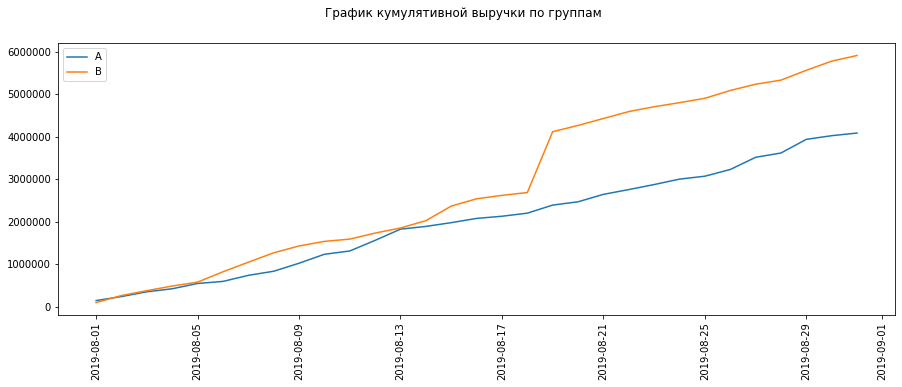

In [11]:
# создадим массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получим агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединим кумулятивные данные в одной таблице и присвоим ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# построим график выручки группы А
plt.figure(figsize =(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# построим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.suptitle('График кумулятивной выручки по группам')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Однако имеется резкий скачет выручки по результам группы B. 
Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы необходимо проанализировать далее.
Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов.

### График кумулятивного среднего чека по группам

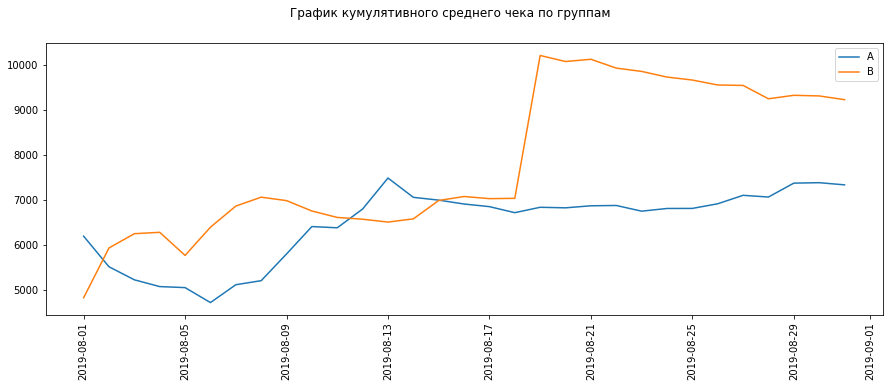

In [12]:
# построим график кумулятивного среднего чека 
plt.figure(figsize =(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.suptitle('График кумулятивного среднего чека по группам')
plt.xticks(rotation=90)
plt.legend() 
plt.show()

Средний чек тоже имеет высплеск в группе B. Однако он становится равномерным ближе к концу теста: установился для группы A и начал снижаться для группы B. Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.


Построим график относительного различия для среднего чека.

### График относительного изменения кумулятивного среднего чека группы B к группе A

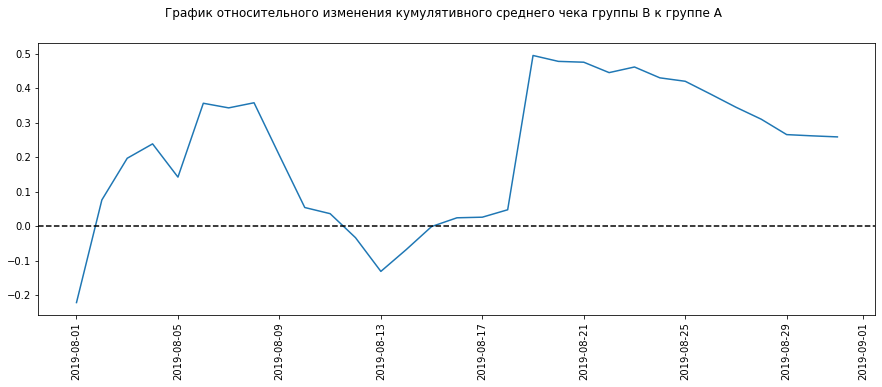

In [13]:
# соберём данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# построим отношение средних чеков
plt.figure(figsize =(15,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.suptitle('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=90)
# добавим ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

В нескольких точках график различия между сегментами резко изменяется. Вероятность найти среди данных крупные заказы и выбросы увеличилась.

Аналогично проанализируем график кумулятивной конверсии. 

### График кумулятивной конверсии по группам

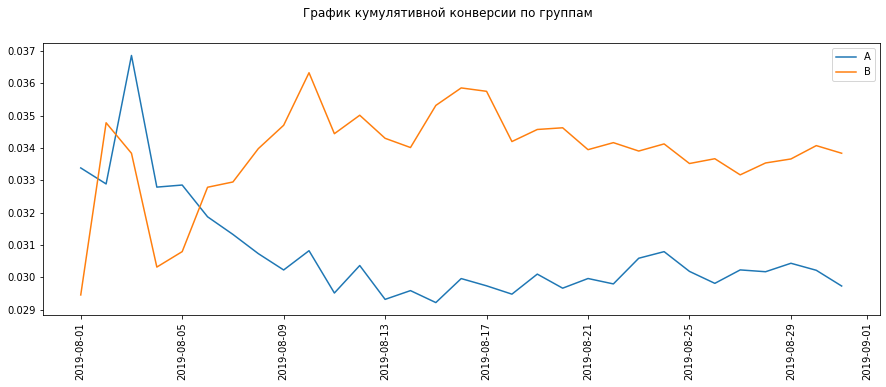

In [14]:
# посчитаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделим данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделим данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# построим график
plt.figure(figsize =(15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.suptitle('График кумулятивной конверсии по группам')
plt.xticks(rotation=90)
plt.legend()
plt.show() 

Во второй половине теста график имеет симметричные участки, в остальном он периодически повторяет друг друга! Группы колебались последовательно около одного значения, но затем конверсия группы B возросла, а конверсия группы A просела и зафиксировалась.


Построим график относительного различия кумулятивных конверсий.

### График относительного изменения кумулятивной конверсии группы B к группе A

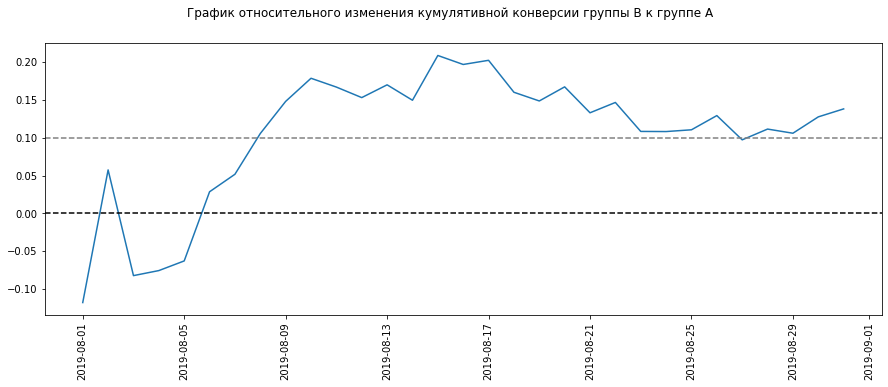

In [15]:
# соберём данные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# построим график
plt.figure(figsize =(15,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.suptitle('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xticks(rotation=90)
plt.show() 

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Потом её конверсия периодически падала, но теперь постепенно растёт.
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. На данном этапе необходимо проверить данные на аномалии и далее делать выводы.

### Точечный график количества заказов по пользователям

Пользователи, совершившие много заказов, влияют на числитель формулы конверсии. Скорее всего, их поведение отличается от нормального. Подсчитаем количество заказов по пользователям и посмотрим на результат.

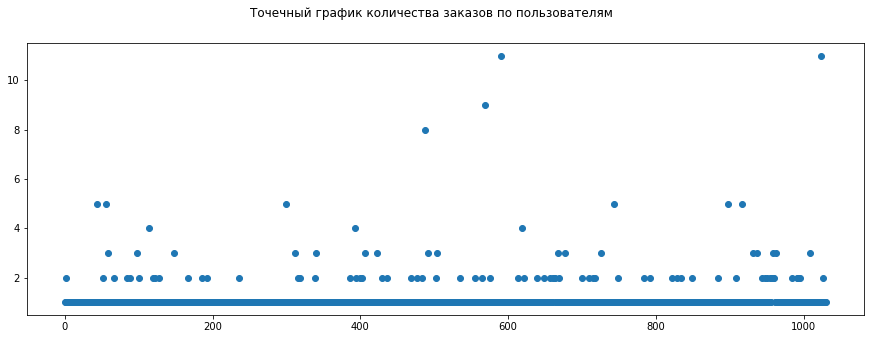

In [16]:
# сгруппируем заказы на пользователя и найдем число заказов
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
# переименуем колонки датафрейма
ordersByUsers.columns = ['userId','orders']
# построим график
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize =(15,5))
plt.scatter(x_values, ordersByUsers['orders'])
plt.suptitle('Точечный график количества заказов по пользователям')
plt.show() 

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-3 заказами тоже значительна. Их точная доля не ясна — непонятно, считать их аномалиями или нет.

Посчитаем выборочные перцентили количества заказов на одного пользователя.

### 95-й и 99-й перцентили количества заказов на пользователя

In [17]:
# посчитаем 95 и 99 перцентили
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа. И всего лишь 1% пользователей заказывали четыре раза.
Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.
Подсчитаем стоимость заказов и посмотрим на результат.

### Точечный график стоимостей заказов

Если дорогой заказ попадёт в одну из групп теста, он сразу же исказит результаты и сделает победителем ту группу, где оказался. При этом такие покупки — редкость, исключение, которое проявилось не из-за тестирования гипотезы, а случайно.

Изучим точечный график распределения стоимостей заказов.

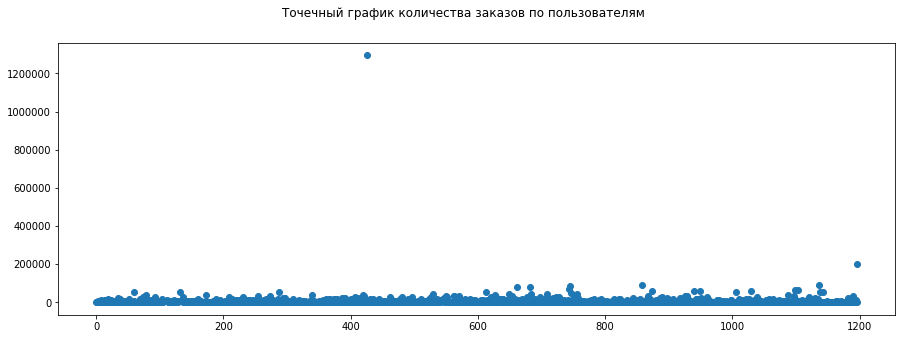

In [18]:
# построим график
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize =(15,5))
plt.scatter(x_values, orders['revenue'])
plt.suptitle('Точечный график количества заказов по пользователям')
plt.show() 

Стоимость распределена равномерно, однако в данных имеется заказ превышающий в разы средний чек - около 1 200 000 рублей. Он значительным образом влияет на распределение весов в тесте.

Посчитаем выборочные перцентили стоимости заказов.

### 95-й и 99-й перцентили стоимости заказов

In [19]:
# посчитаем 95 и 99 перцентили
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233 рублей. В эти данные попадают аномальные значения. Посмотрим на статистические показатели данных теста в данных с аномалиями и данных без них.

### Статистическая значимость различий в конверсии между группами по «сырым» данным

Для начала посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей. Для проверки статистических тестов зададим нулевую и альтернативную гипотезу - она будет общей для проверки "сырых" и обработанных данных.

- Нулевая гипотеза: статистически значимых различий в конверсии между группами A и B нет.

- Альтернативная гипотеза: присутствуют статистически значимые различия в конверсии между группами A и B.

In [20]:
# выберем посетителей группы А
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
# посчитаем кумулятивную сумму посетителей группы B
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
# выберем посетителей группы А
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
# посчитаем кумулятивную сумму посетителей группы B
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
# посчитаем количество заказов в день и стоимость группы A
ordersADaily = orders[orders['group']=='A'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
# посчитаем куммулятивные значения группы A
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']
# посчитаем количество заказов и их стоимость группы B
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
# посчитаем кумулятивные значения группы B
ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']
# соберем данные в один датафрейм
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

Среди данных выберем пользователей, которые совершили заказ хотя бы раз по группе A и по группе B и посчитаем количество заказов.

In [21]:
# создадим переменную для пользователей которые заказывали хотя бы раз группа A
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorid', 'orders']
# создадим переменную для пользователей которые заказывали хотя бы раз группа B
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorid', 'orders']
# создадим переменную, где пользователям из разных групп будет соответствовать количество заказов группа A
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
# создадим переменную, где пользователям из разных групп будет соответствовать количество заказов группа B
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Проведем статистистический тест Манна-Уитни и выведем результаты.

In [22]:
# проверим конверсии критерием Манна-Уитни
print('p-value:' ,"{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
# выведем относительный прирост конверсии группы B
print('\nотношение группы A и B:' ,"{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

p-value: 0.017

отношение группы A и B: 0.138


Вывод: Даже по «сырым» данным имеются различия в конверсии групп A и B.
Первое число — p-value = 0.008 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Однако относительный выигрыш группы B равен 13.8% — второе число в выводе.

Чтобы рассчитать статистическую значимость различий в среднем чеке между группами, передадим критерию mannwhitneyu() данные о выручке с заказов.

А ещё найдём относительные различия в среднем чеке между группами.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

 Для проверки статистических тестов зададим нулевую и альтернативную гипотезу - она будет общей для проверки "сырых" и обработанных данных.

- Нулевая гипотеза: статистически значимых различий в среднем чеке заказа между группами A и B нет.

- Альтернативная гипотеза: присутствуют статистически значимые различия в среднем чеке заказа между группами A и B.

In [23]:
# # применим статистический критерий Манна-Уитни к полученным выборкам
print('p-value:' ,"{0:.3f}".format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1], alternative = 'two-sided'))
print('\nотношение группы A и B:',"{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.365

отношение группы A и B: 0.259


Вывод: P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным


Найденные ранее 95-й и 99-й перцентили средних чеков равны 28 000 и 58 233 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и пользователей с дорогими заказами. 

In [24]:
# сделаем срез пользователей с числом заказов больше 2
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorid'], ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorid']], axis = 0)
# сделаем срез пользователей с суммой заказа дороже 28 000 рублей
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorid']
# объединим данные
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
# узнаем количество аномальных пользователей
print(abnormalUsers.shape)

(74,)


Всего 74 аномальных пользователя. Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным.

In [25]:
# подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)
# применим статистический критерий Манна-Уитни к полученным выборкам
print('p-value:' ,"{0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered , alternative = 'two-sided')[1]))
# выведем относительный прирост конверсии группы B
print('\nотношение группы A и B:',"{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.013

отношение группы A и B: 0.173


Результаты по конверсии практически не изменились - p-value = 0.007 меньше 0.05. Отрыв группы B увеличился до 17.3%  Посмотрим на результаты по среднему чеку.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [26]:
# применим статистический критерий Манна-Уитни к полученным выборкам
print('p-value:' ,"{0:.3f}".format(st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'])[1], alternative = 'two-sided'))
# выведем относительный прирост конверсии группы B
print('\nотношение группы A и B:',"{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

p-value: 0.369

отношение группы A и B: -0.020


P-value увеличился незначительно и все еще причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 
Аномалии в части высокой стоимости заказа не повлияли на различия по среднему чеку в результатах теста.

## Решение по результатам теста 

По результатам проведенного анализа теста мы имеем следующие факты:

- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий;

- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

- График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения;

- График различия среднего чека колеблется: он-то и позволил вам найти аномалии. Сделать из этого графика определённые выводы нельзя.

Исходя из обнаруженных фактов, тест следует остановить, зафиксировать победу группы B и перейти к проверке следующей гипотезы.